# Cyclic Orthogonal Convolutions

The aim of this notebook is to present the main results of the paper: "Cyclic orthogonal convolutions for long-rangeintegration of features".

It is divided in four main sections corresponding to the three main experiments studied in the paper.

- CIFAR-10
- ImageNet, Stylized-ImageNet and Cue Conflict
- Receptive fields
- Pathfinder

In each section, the user can load a pre-trained model and evaluate its performance.
A few of the models showed in the paper are available in this repository, one for each set of parameters.
This notebook is intended be used for evaluation only, not for training. 

Note that the code runs on GPU. This notebook runs on Tensorflow 1.15.0 and Python 3.6.8.

When loading a model, the option model="CNN" refers to a standard convolutional network, while model="CycleNet" corresponds to the new proposed architecture. Other parameters corresponds to those explained in the paper: 'depth' is the number of layers, 'kernel' is the kernel size.

### Imports and setting up the environement

In [1]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.1)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from layers.CNNCycle import CNNCycle
from layers.BilinearInterpolate3D import BilinearInterpolate3D
from layers.CycleNetCycle import NetXCycle
from image_classification.imagenet.helpers.imagenet_dataset import get_dataset
from image_classification.imagenet.helpers.imagenet_helpers import top_1_accuracy, top_5_accuracy
from image_classification.cifar10.helpers.cifar10_dataset import *
from saliency.helpers.saliency import *
from image_classification.imagenet.helpers.cue_conflict_mapping import superclasses, superclasses_names, predicted_superclass
from sklearn.metrics import accuracy_score
import pickle

In [3]:
# # Setting a GPU memory fraction used (if desired) to limit resource usage
# gpu_memory_fraction = 0.4
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
# tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [4]:
# Set larger batch size to speed up evaluation times, or smaller to avoid OOM issues.
BATCH_SIZE = 64

## CIFAR-10

- Load dataset
- Load model
- Show model summary
- Evaluate model

In [5]:
# Set dataset path and load dataset
cifar_dataset_path = 'image_classification/cifar10/data/CIFAR-10_test.h5'
x_test, y_test = read_h5_dataset(cifar_dataset_path)

In [6]:
# Load desired model
model = "CNN"    # "CycleNet" or "CNN"
depth = 3          # 3, 6, 9, 12, 15 or 18
cifar_model_path = 'image_classification/cifar10/models/'+model+'_models/'+model+'_cifar10_depth'+str(depth)+'.h5'
cifar_model = load_model(cifar_model_path, custom_objects={'BilinearInterpolate3D': BilinearInterpolate3D})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [7]:
# Print model summary
cifar_model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 80)        2240      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 32, 32, 80)        320       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 80)        0         
_________________________________________________________________
bilinear_interpolate3d (Bili (None, 5, 5, 5)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 5)           230       
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 5, 5, 5)           20  

In [8]:
# Evaluating 
metrics_cifar = cifar_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

10000/10000 [==============================] - 1s 134us/sample - loss: 1.5254 - acc: 0.4537


## ImageNet, Stylized-ImageNet and Cue Conflict

<font style="color:red;font-size:17px;">Note: Due to copyright restrictions, it is not possible for us to share the ImageNet and Stylized Imagenet dataset.</font>

It is possible to source the ImageNet dataset online (at http://image-net.org/download) and the Stylized-ImageNet dataset can be generated following the instructions and scripts at https://github.com/rgeirhos/Stylized-ImageNet.
In order to load the datasets for training and/or evaluation we use the tensorflow records format.
We provide the scripts that can be used to convert the ImageNet and Stylized-Imagenet datasets to this format, these are located in the image_classification/imagenet/helpers/convert_tfrecords folder in this repository.
Each of the models trained on ImageNet can be used for testing on: ImageNet, Stylized-ImageNet and Cue conflict.

- Show model summary
- Load model from a directory

Then for each dataset:
- Initialize dataset generator
- Evaluate model


In [9]:
IMAGENET_IMAGE_SIZE = 128

# Load model
nr_initial_CNN_cycles = 0                 # a number between 0 and 5 (included)
imagenet_model_path = "image_classification/imagenet/models/CNN-CycleNet_models/CNN"+str(nr_initial_CNN_cycles)+"-CycleNet"+str(5-nr_initial_CNN_cycles)+"_imagenet.h5" 
imagenet_model = load_model(imagenet_model_path, custom_objects={'NetXCycle': NetXCycle, 'BilinearInterpolate3D': BilinearInterpolate3D, 'CNNCycle': CNNCycle, "top_1_accuracy": top_1_accuracy, "top_5_accuracy": top_5_accuracy, "tf": tf})

In [10]:
# Print model summary
imagenet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
bilinear_interpolate3d (Bili (None, 106, 106, 106)     0         
_________________________________________________________________
net_x_cycle (NetXCycle)      (None, 106, 106, 106)     304962    
_________________________________________________________________
bilinear_interpolate3d_1 (Bi (None, 106, 106, 106)     0     

### ImageNet

In [11]:
# Initialise the dataset generator for ImageNet
imagenet_dataset_path = 'path/to/ImageNet/dataset' # substitute here the path to the imagenet dataset in tensorflow records format
ds_valid_imagenet = get_dataset(imagenet_dataset_path, 'validation', BATCH_SIZE, image_size=IMAGENET_IMAGE_SIZE)


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.



Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


In [12]:
# Evaluating
metrics_imagenet = imagenet_model.evaluate(x=ds_valid_imagenet, steps=50000 // BATCH_SIZE)

781/781 [==============================] - 297s 381ms/step - loss: 2.2466 - acc: 0.4919 - top_1_accuracy: 0.4919 - top_5_accuracy: 0.7386


### Stylized ImageNet

In [13]:
# Initialise the dataset generator for Stylized-ImageNet
stylized_imagenet_dataset_path = 'path/to/Stylized-ImageNet/dataset' # substitute here the path to the imagenet dataset in tensorflow records format
ds_valid_stylized = get_dataset(stylized_imagenet_dataset_path, 'validation', BATCH_SIZE, image_size=IMAGENET_IMAGE_SIZE)

In [14]:
# Evaluating
metrics_stylized = imagenet_model.evaluate(x=ds_valid_stylized, steps=50000 // BATCH_SIZE)

781/781 [==============================] - 300s 384ms/step - loss: 8.6678 - acc: 0.0318 - top_1_accuracy: 0.0318 - top_5_accuracy: 0.0890


### Cue Conflict

In [15]:
!tar -xvf image_classification/imagenet/data/cue_conflict/cue_conflict_128.tar.xz
cue_conflict_dataset_path = 'image_classification/imagenet/data/cue_conflict/cue_conflict_128.pkl'

# Load cue conflict
with open(cue_conflict_dataset_path,'rb') as f:
    cc_X, cc_y_true = pickle.load(f)
!rm cue_conflict_128.pkl

In [16]:
# Evaluating
cc_y_pred = list([predicted_superclass(imagenet_class_probabilities.tolist())[1] for imagenet_class_probabilities in imagenet_model.predict(cc_X)]) 
cue_conflict_accuracy = accuracy_score(cc_y_true, cc_y_pred)
print("The cue conflict dataset accuracy for the selected model is:" , cue_conflict_accuracy)

The cue conflict dataset accuracy for the selected model is: 0.1640625


## Receptive fields plots
- Load and scale a sample image
- Choose layer list and number of nodes to sample
- Plot receptive field

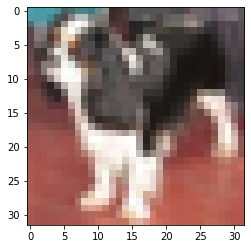

In [17]:
# Load and scale a sample image at random
image_index = np.random.randint(0, x_test.shape[0]-1)
image = x_test[image_index]
plt.imshow((image * NORMALIZING_CONST + CENTRALIZING_CONST)/QUANTIZATION_SIZE)

Choose two layers to visualize the receptive field.

Default is:
- After first convolution (layer number = 1)
- After last cycle (layer number = 15+(depth/3-1)*16)

Change numbers in 'layer_list' to visualize receptive fields in other layers.
Add more elements to 'layer_list' to visualize more layers.

'no_of_nodes' is the number of neurons for which the receptive field is visualized, in each layer. 

In [18]:
# Choose layer list and number of nodes to sample
no_of_nodes = 3
layer_list = [1, int(15+(depth/3-1)*16)]   # Add instructions on which layer is being checked
saliency = get_saliency_maps_and_fitted_ellipses(cifar_model, layer_list, no_of_nodes, image)

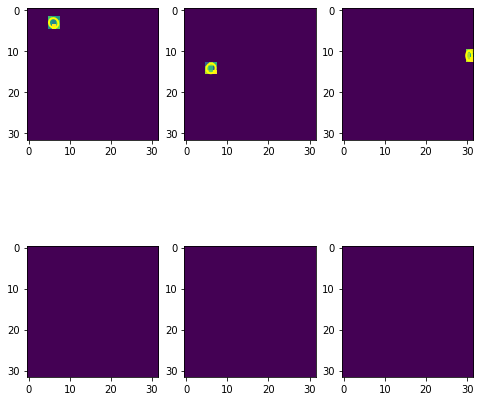

In [19]:
# Plot receptive field. If a node is deactivated, a blank image will be displayed.
print_images(*saliency)

## Receptive fields stats
- Choose a layer (default is last cycle), number of nodes and images to sample.
- Compute and display receptive field statistics. Deactivated nodes do not participate in the statistics.

The output displays the mean and standard deviation of the receptive field size.

In [20]:
# Set variables controlling layer number, number of images, number of nodes and image indices.
layer = int(15+(depth/3-1)*16)
no_of_images = 2
no_of_nodes = 2
image_indices = np.random.randint(0, x_test.shape[0]-1, size=no_of_images)

In [21]:
# Compute statistics 
sqrt_traces = get_saliency_stats(cifar_model, layer, no_of_nodes, x_test[image_indices])
print("Mean:", np.mean(sqrt_traces))
print("Std:", np.std(sqrt_traces))

Mean: 12.692104171753089
Std: 0.9971108365644188


## Pathfinder

The orginal test dataset included 100000 images, following the test-training split of the original pathfinder paper https://arxiv.org/abs/1805.08315. To prevent possible memory problems that the user my encounter while loading the data, here we provide a subset of 10000 random images of the test data employed for the evaluation. 

- Load dataset
- Set model from a directory
- (Optional) For large models of kernel size 20, run a script to untar and reconstruct the model.
- Load model
- Show model summary
- Evaluate model

'length' refers to the the path lengths of the pathfinder dataset (see paper)

In [22]:
model = "CycleNet"    # "CycleNet" or "CNN"
length = 9              # 6, 9 or 14
kernel = 8              # 4, 8, 12 or 20

In [23]:
pathfinder_dataset_path = 'pathfinder/data/pathfinder_path'+str(length)+'_test.h5'
x_test, y_test = read_h5_dataset(pathfinder_dataset_path, scale = False)

In [24]:
# Specify the model path (either directory or h5 file) - no trailing `/` for kernel size 20, otherwise the .h5 file directly
pathfinder_model_path = 'pathfinder/models/'+model+'_models/'+model+'_pathfinder'+str(length)+'_kernelsize'+str(kernel)

# Identify if the path given identifies a h5 file or a directory requiring untarring
# If untarring required, extract model and update model path to extracted h5 file
if kernel==20:
    !sh pathfinder/helpers/untar.sh $pathfinder_model_path
    a = !ls $pathfinder_model_path
    model = [i for i in a if i.find('.h5') != -1][0]
    pathfinder_model_path = pathfinder_model_path + '/' + model
else:
    pathfinder_model_path += '.h5'

In [25]:
# Load model
pathfinder_model = load_model(pathfinder_model_path, custom_objects={'BilinearInterpolate3D':BilinearInterpolate3D,
                                                                     'NetXCycle': NetXCycle})
# Remove extracted model file if required
if kernel==20:
    !rm $pathfinder_model_path

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
# Print model summary
pathfinder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 128)     8320      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 128, 128, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 128)     0         
_________________________________________________________________
net_x_cycle (NetXCycle)      (None, 128, 128, 128)     3147648   
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0     

Note that the orthogonal convolution cycle is defined expicitly for the CIFAR models. 'model.summary()' shows the sequence of convolution and permutations; for the pathfinder models, instead, the cycles are wrapped using a "NetXCycle" layer. The CIFAR models are defined explicitly to allow computing the receptive fields at different stages.

In [27]:
# Evaluating 
scores = pathfinder_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

10000/10000 [==============================] - 25s 3ms/sample - loss: 0.2660 - acc: 0.8902
